In [10]:
#!pip install -r requirements.txt

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import networkx as nx
import pickle


from tqdm import trange
from numpy.random import default_rng

from dag_gflownet.env import GFlowNetDAGEnv
from dag_gflownet.gflownet import DAGGFlowNet
from dag_gflownet.utils.replay_buffer import ReplayBuffer
from dag_gflownet.utils.factories import get_scorer
from dag_gflownet.utils.gflownet import posterior_estimate
from dag_gflownet.utils.metrics import expected_shd, expected_edges, threshold_metrics
from dag_gflownet.utils import io

/Users/sjleslie/miniconda-jan3/envs/dag_gflownet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt


# Utilities
Function main() is taken from train.py. 
Class Args is to get around the use of argparser in the original code and streamline the number of arguments

In [3]:
#cut and pasted from train.py
def main(args):
    rng = default_rng(args.seed)
    key = jax.random.PRNGKey(args.seed)
    key, subkey = jax.random.split(key)

    # Create the environment
    scorer, data, graph = get_scorer(args, rng=rng)
    env = GFlowNetDAGEnv(
        num_envs=args.num_envs,
        scorer=scorer,
        num_workers=args.num_workers,
        context=args.mp_context
    )

    # Create the replay buffer
    replay = ReplayBuffer(
        args.replay_capacity,
        num_variables=env.num_variables
    )

    # Create the GFlowNet & initialize parameters
    gflownet = DAGGFlowNet(
        delta=args.delta,
        update_target_every=args.update_target_every
    )
    optimizer = optax.adam(args.lr)
    params, state = gflownet.init(
        subkey,
        optimizer,
        replay.dummy['adjacency'],
        replay.dummy['mask']
    )
    exploration_schedule = jax.jit(optax.linear_schedule(
        init_value=jnp.array(0.),
        end_value=jnp.array(1. - args.min_exploration),
        transition_steps=args.num_iterations // 2,
        transition_begin=args.prefill,
    ))

    # Training loop
    indices = None
    observations = env.reset()
    with trange(args.prefill + args.num_iterations, desc='Training') as pbar:
        for iteration in pbar:
            # Sample actions, execute them, and save transitions in the replay buffer
            epsilon = exploration_schedule(iteration)
            actions, key, logs = gflownet.act(params.online, key, observations, epsilon)
            next_observations, delta_scores, dones, _ = env.step(np.asarray(actions))
            indices = replay.add(
                observations,
                actions,
                logs['is_exploration'],
                next_observations,
                delta_scores,
                dones,
                prev_indices=indices
            )
            observations = next_observations

            if iteration >= args.prefill:
                # Update the parameters of the GFlowNet
                samples = replay.sample(batch_size=args.batch_size, rng=rng)
                params, state, logs = gflownet.step(params, state, samples)

                pbar.set_postfix(loss=f"{logs['loss']:.2f}", epsilon=f"{epsilon:.2f}")

    # Evaluate the posterior estimate
    posterior, _ = posterior_estimate(
        gflownet,
        params.online,
        env,
        key,
        num_samples=args.num_samples_posterior,
        desc='Sampling from posterior'
    )

    # Compute the metrics
    ground_truth = nx.to_numpy_array(graph, weight=None)
    results = {
        'expected_shd': expected_shd(posterior, ground_truth),
        'expected_edges': expected_edges(posterior),
        **threshold_metrics(posterior, ground_truth)
    }

    # Save model, data & results
    args.output_folder.mkdir(exist_ok=True)
    with open(args.output_folder / 'arguments.json', 'w') as f:
        json.dump(vars(args), f, default=str)
    data.to_csv(args.output_folder / 'data.csv')
    with open(args.output_folder / 'graph.pkl', 'wb') as f:
        pickle.dump(graph, f)
    io.save(args.output_folder / 'model.npz', params=params.online)
    replay.save(args.output_folder / 'replay_buffer.npz')
    np.save(args.output_folder / 'posterior.npy', posterior)
    with open(args.output_folder / 'results.json', 'w') as f:
        json.dump(results, f, default=list)
    
    #added
    print(results)


In [4]:
#A hack to get around the fact they used ArgParser without having to modify every function ...
class Args:
     
      def __init__(self, graph, model=None, samples=None, num_variables=5, num_edges=5,
                   num_samples=100, score="bde", num_envs=8, scorer_kwargs={}, prior="uniform", prior_kwargs={},
                   lr=1e-5,delta=1., batch_size=32, num_iterations=100000, replay_capacity=100000,
                   prefill=1000,min_exploration=0.1, update_epsilon_every=10, num_samples_posterior=1000,
                   update_target_every=1000, seed=0, num_workers=4, mp_context="spawn",
                   output_folder="output"):
          
          self.graph=graph
          self.model=model
          self.samples=samples
          self.num_variables = num_variables
          self.num_edges = num_edges
          self.num_samples = num_samples
          self.score = score
          self.num_envs = num_envs
          self.scorer_kwargs = scorer_kwargs
          self.prior = prior
          self.prior_kwargs = prior_kwargs
          self.lr = lr
          self.delta = delta
          self.batch_size = batch_size
          self.num_iterations = num_iterations
          self.replay_capacity = replay_capacity
          self.prefill = prefill
          self.min_exploration = min_exploration
          self.update_epsilon_every = update_epsilon_every
          self.num_samples_posterior = num_samples_posterior
          self.update_target_every = update_target_every
          self.seed = seed
          self.num_workers = num_workers
          self.mp_context = mp_context
          self.output_folder = Path(output_folder)


# A simplified call to a train a GFlowNet
A lot of functionality is masked for simplicity; see Args class above

In [5]:
def train_gflownet(graph="custom", model=None, samples=None, score="bde", prior="uniform",
                   batch_size=32, num_iterations=10000, 
                   output_folder="output"):
    
    args = Args(graph=graph, model=model, samples=samples, score=score, prior=prior, batch_size=batch_size, num_iterations=num_iterations,
                   output_folder=output_folder)
    main(args)

# Generate samples from a discrete Bayesian network

In [6]:
#cut and pasted, then slightly modified, from sample.py
def sample_from_discrete(model, num_samples):
    """Sample from a discrete model using ancestral sampling."""
    if not isinstance(model, BayesianNetwork):
        raise ValueError('The model must be an instance of BayesianNetwork')
    sampler = BayesianModelSampling(model)
    samples = sampler.forward_sample(size=num_samples, show_progress=False)

    # Convert values to pd.Categorical for faster operations
    for node in samples.columns:
        cpd = model.get_cpds(node)
        samples[node] = pd.Categorical(samples[node], categories=cpd.state_names[node])

    return samples

# Get the posterior in a nice form

In [7]:
def process_posterior(path, model):
    posterior = np.load(path)
    dags, count = np.unique(posterior, axis=0, return_counts=True)
    dags = dags[np.argsort(count)][::-1]
    count = np.sort(count)[::-1]

    graphs = []
    for i in range(dags.shape[0]):
        graph = nx.from_numpy_array(dags[i], create_using=nx.DiGraph)
        nx.relabel_nodes(graph, {i:label for i, label in enumerate(list(model.nodes))},copy=False)
        graphs.append(graph)
    
    return dags, count, graphs

# Graph the DAGs returned in the posterior

In [8]:
def graph_posterior(graphs, count, max_num=10):

    #check this line
    max_num = np.min([max_num,len(graphs)])

    for i in range(max_num):
        nx.draw_networkx(graphs[i])
        print(f"probability of graph: {count[i]/1000}")
        plt.show()
        print("\n")
        print("\n")

# Now we can define a model using pgmpy and train on it pretty easily!

In [9]:
#R: Raining, S: Sprinker on, G: Grass wet. 0=no, 1=yes
#G=0: grass is not wet; G=1: grass is wet
model = BayesianNetwork([("R","S"),("S","G"),("R","G")])
cpd_R = TabularCPD(variable="R", variable_card=2, values=[[0.8],[0.2]])
cpd_S = TabularCPD(variable="S", variable_card=2, values=[[0.2,0.9],[0.8,0.1]], evidence=["R"], evidence_card=[2])
cpd_G = TabularCPD(variable="G", variable_card=2, values=[[0.99,0.1,0.2,0.01],[0.01,0.9,0.8,0.99]], evidence=["R", "S"], evidence_card=[2,2])
model.add_cpds(cpd_R, cpd_S, cpd_G)

/var/folders/k8/n_2s8vh107ndn49xgmw8zhvh0000gn/T/ipykernel_23345/2207347324.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  cpd_S = TabularCPD(variable="S", variable_card=2, values=[[0.2,0.9],[0.8,0.1]], evidence=["R"], evidence_card=[2])
/var/folders/k8/n_2s8vh107ndn49xgmw8zhvh0000gn/T/ipykernel_23345/2207347324.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  cpd_G = TabularCPD(variable="G", variable_card=2, values=[[0.99,0.1,0.2,0.01],[0.01,0.9,0.8,0.99]], evidence=["R", "S"], evidence_card=[2,2])


In [10]:
samples = sample_from_discrete(model,100)

In [16]:
train_gflownet(model=model,samples=samples, num_iterations=2000,output_folder="test")

Sampling from posterior: 100%|██████████| 1000/1000 [00:04<00:00, 229.08it/s]

{'expected_shd': 1.934, 'expected_edges': 2.228, 'fpr': array([0.        , 0.16666667, 0.16666667, 0.5       , 0.5       ,
       1.        ]), 'tpr': array([0.        , 0.        , 0.33333333, 0.33333333, 1.        ,
       1.        ]), 'roc_auc': 0.6111111111111112, 'precision': array([0.33333333, 0.5       , 0.4       , 0.25      , 0.33333333,
       0.5       , 0.        , 1.        ]), 'recall': array([1.        , 1.        , 0.66666667, 0.33333333, 0.33333333,
       0.33333333, 0.        , 0.        ]), 'prc_auc': 0.3416666666666667, 'ave_prec': 0.4666666666666667}


# Inspect the posterior

In [21]:
dags, count, graphs = process_posterior("test/posterior.npy",model)

In [18]:
dags

array([[[0, 1, 0],
        [0, 0, 0],
        [0, 1, 0]],

       [[0, 0, 0],
        [1, 0, 1],
        [1, 0, 0]],

       [[0, 1, 1],
        [0, 0, 0],
        [0, 1, 0]],

       [[0, 1, 0],
        [0, 0, 0],
        [1, 1, 0]],

       [[0, 0, 1],
        [1, 0, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 0, 0],
        [1, 1, 0]]])

In [19]:
count

array([772,  65,  57,  43,  36,  27])

probability of graph: 0.772


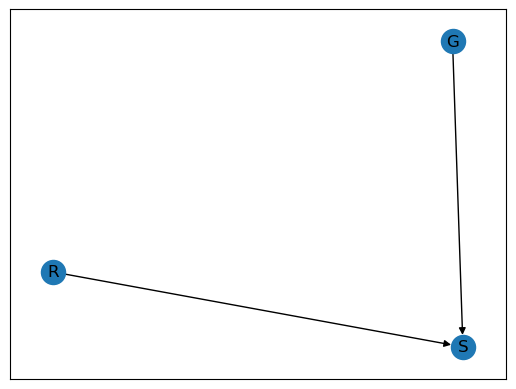





probability of graph: 0.065


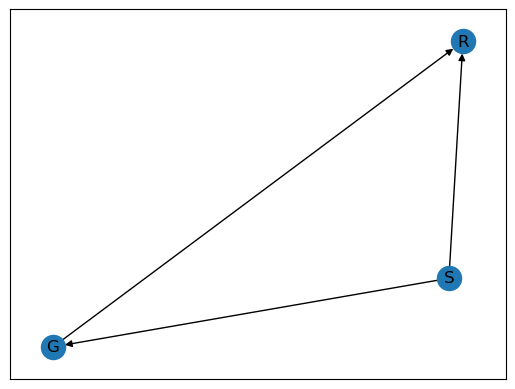





probability of graph: 0.057


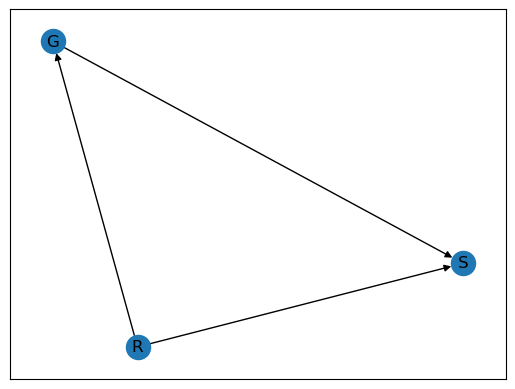





probability of graph: 0.043


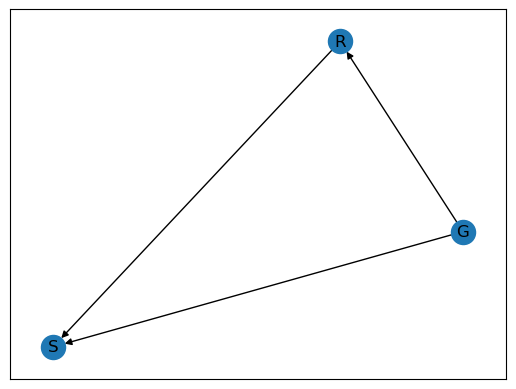





probability of graph: 0.036


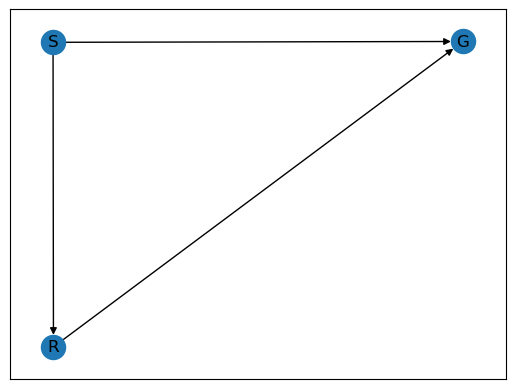





probability of graph: 0.027


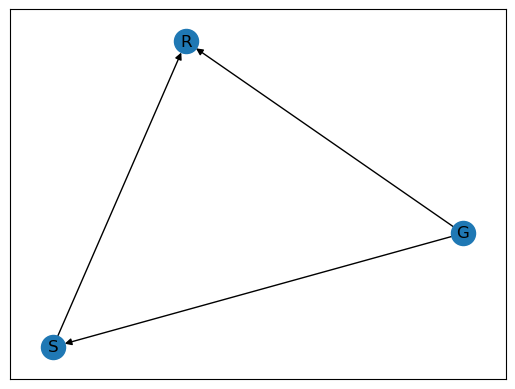

In [20]:
graph_posterior(graphs,count)

This didn't do such a great job of learning the original structure. Trying again with more iterations.

In [22]:
train_gflownet(model=model,samples=samples, num_iterations=20000,output_folder="test2")

Sampling from posterior: 100%|██████████| 1000/1000 [00:03<00:00, 260.54it/s]


{'expected_shd': 1.741, 'expected_edges': 2.438, 'fpr': array([0.        , 0.        , 0.16666667, 0.16666667, 0.5       ,
       1.        ]), 'tpr': array([0.        , 0.33333333, 0.33333333, 1.        , 1.        ,
       1.        ]), 'roc_auc': 0.888888888888889, 'precision': array([0.33333333, 0.5       , 0.6       , 0.75      , 0.66666667,
       0.5       , 1.        , 1.        ]), 'recall': array([1.        , 1.        , 1.        , 1.        , 0.66666667,
       0.33333333, 0.33333333, 0.        ]), 'prc_auc': 0.7638888888888888, 'ave_prec': 0.8055555555555556}


probability of graph: 0.562


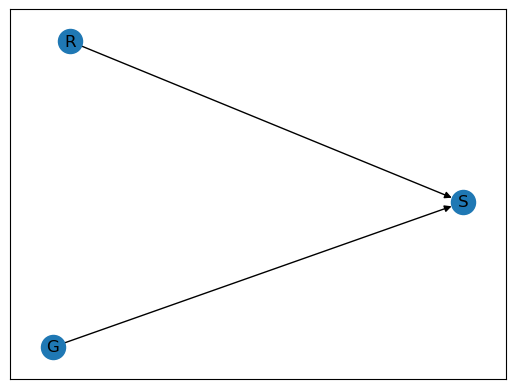





probability of graph: 0.091


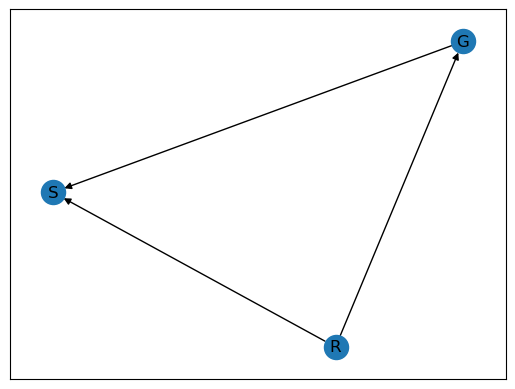





probability of graph: 0.088


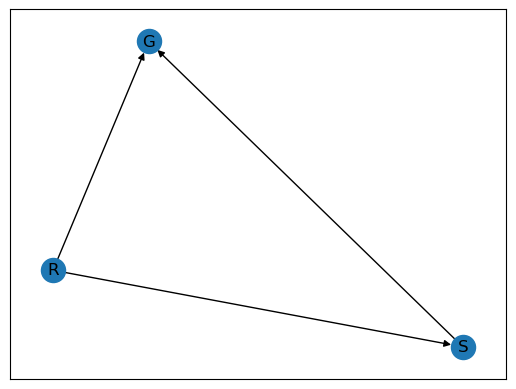





probability of graph: 0.069


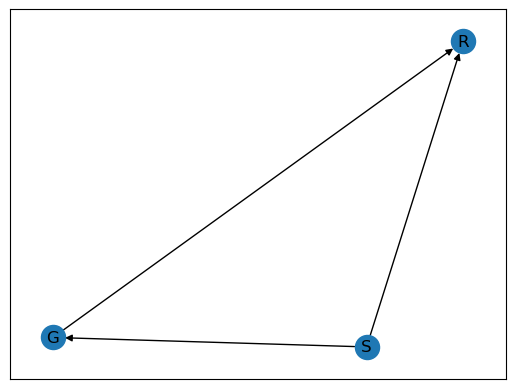





probability of graph: 0.068


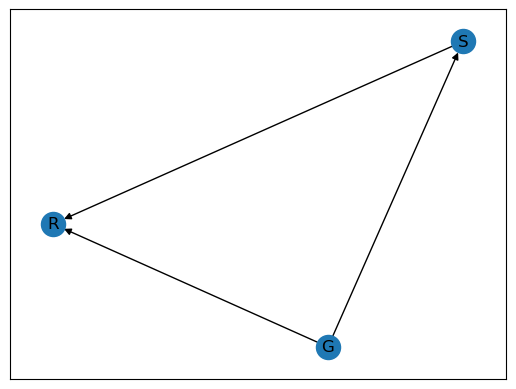





probability of graph: 0.062


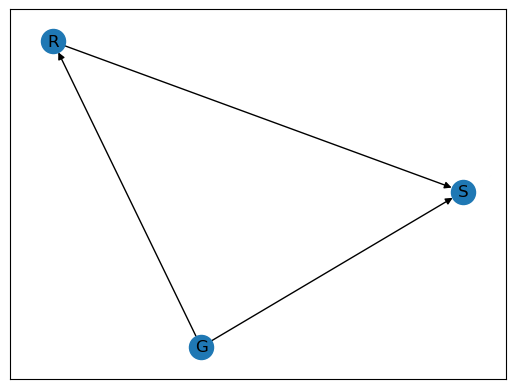





probability of graph: 0.06


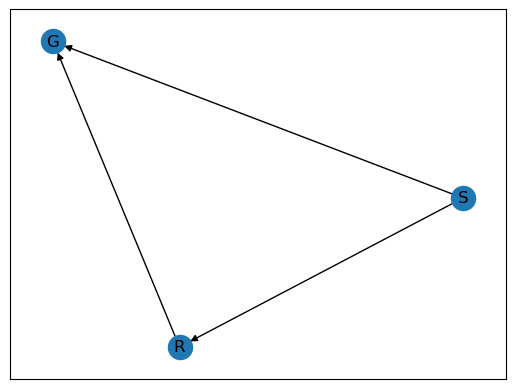

In [23]:
dags, count, graphs = process_posterior("test2/posterior.npy",model)
graph_posterior(graphs,count)

Same thing. But the issue seems to be with the example, not with the GFlowNet. In particular, the preferred network has a higher BDeu score given the data. 

(I believe that BDeu score is BDe score with a uniform prior over DAGs (which was used in the model). Does that sound right? I saw some conflicting information in this connection.)

In [24]:
from pgmpy.estimators import BDeuScore

In [25]:
# Ground truth
BDeuScore(samples).score(BayesianNetwork([("R","S"),("S","G"),("R","G")]))

-150.00050352915486

In [26]:
#GFlowNet preferred graph
BDeuScore(samples).score(BayesianNetwork([("R","S"),("G","S")]))

-149.2668015817445